In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import joblib
import ta
import os

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [39]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Data Gathering 


In [40]:
STOCK_SYMBOLS = [
	"RELIANCE.BO",
	"TCS.BO",
	"INFY.BO",
	"HDFCBANK.BO",
	"HINDUNILVR.BO",
	"BAJFINANCE.BO",
	"ITC.BO",
	"ICICIBANK.BO",
	"KOTAKBANK.BO",
	"LT.BO",
	"ASIANPAINT.BO",
	"HCLTECH.BO",
	"WIPRO.BO",
	"SUNPHARMA.BO",
	"ONGC.BO",
	"ULTRACEMCO.BO",
	"MARUTI.BO",
	"POWERGRID.BO",
	"TITAN.BO",
	"NTPC.BO",
	"BHARTIARTL.BO",
	"SBIN.BO",
	"TATAMOTORS.BO",
]

In [41]:
#Download Data
start_date = "2015-01-01"
end_date = str(datetime.now().date())

dfs = {}
for ticker in STOCK_SYMBOLS:
    df = yf.download(ticker, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    dfs[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [42]:
#Saving Training Dates
train_dates = {}

for ticker in STOCK_SYMBOLS:
    train_dates[ticker] = pd.to_datetime(dfs[ticker]["Date"])

# Preprocessing

In [43]:
#SMA: Simple Moving Average, which is a technical indicator that calculates the average price of a stock over a given period of time.

SMA_WINDOW = 10
for ticker in STOCK_SYMBOLS:
    dfs[ticker]['SMA'] = dfs[ticker]['Close'].rolling(window=SMA_WINDOW).mean()

#RSI: Relative Strength Index, a technical indicator used to assess the strength of a stock or other financial instrument.

RSI_WINDOW = 14
for ticker in STOCK_SYMBOLS:
    dfs[ticker]['RSI'] = ta.momentum.rsi(dfs[ticker]['Close'].squeeze(), window=RSI_WINDOW)

#removing the Date and Volume Column
for ticker in STOCK_SYMBOLS:
    dfs[ticker] = dfs[ticker][['Close', 'SMA', 'RSI']]

#removing last 14 days as RSI and SMA are NaN
for ticker in STOCK_SYMBOLS:
    dfs[ticker] = dfs[ticker].iloc[14:]
    dfs[ticker].reset_index(drop=True, inplace=True)

In [44]:
# creating scaler and scaled data dict
scaler = {}
dfs_training = {}

for ticker in STOCK_SYMBOLS:
    scaler[ticker] = StandardScaler()
    dfs_training[ticker] = scaler[ticker].fit_transform(dfs[ticker])

In [45]:
#Defining train and test dicts
X = {ticker: [] for ticker in STOCK_SYMBOLS}
y = {ticker: [] for ticker in STOCK_SYMBOLS}
#Defining past and future days
d_future = 1
d_past = 21

In [46]:
#Updating X and y
for ticker in STOCK_SYMBOLS:
    data = dfs_training[ticker]
    for i in range(d_past, len(data) - d_future + 1):
        X[ticker].append(data[i - d_past:i, :])
        y[ticker].append(data[i + d_future - 1, 0])

In [47]:
#converting X and y to numpy arrays
for ticker in STOCK_SYMBOLS:
    X[ticker] = np.array(X[ticker])
    y[ticker] = np.array(y[ticker])

# Model Creation

In [48]:
#defining model
def create_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', return_sequences=True, input_shape=(X["RELIANCE.BO"].shape[1], X["RELIANCE.BO"].shape[2])))
    model.add(LSTM(units=units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')
    print(model.summary())
    return model

In [49]:
create_lstm_model(units=50, dropout_rate=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 21, 50)            10800     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
#early stopping
early_stopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
best_models = {}

In [51]:
#tuning hyperparameter
param_grid = {
    'model__units': [50, 100],
    'model__dropout_rate': [0.2],
    'epochs': [10, 20],
    'batch_size': [16, 32],
    'fit__callbacks': [[early_stopping]]  # Include callbacks in param_grid
}

In [54]:
# Training the model for each stock with static parameters:
for ticker in STOCK_SYMBOLS:
    print(f"\n\nTraining model for {ticker} ...")

    X_stock = X[ticker]
    y_stock = y[ticker]
    
    # Create model using your existing function with static parameters
    model = create_lstm_model(units=50, dropout_rate=0.2)
    
    # Train the model
    history = model.fit(
        X_stock, y_stock,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Store the trained model
    best_models[ticker] = model
    
    # Optional: Print training results
    print(f"Final training loss for {ticker}: {history.history['loss'][-1]:.4f}")
    if 'val_loss' in history.history:
        print(f"Final validation loss for {ticker}: {history.history['val_loss'][-1]:.4f}")
    
print("\nAll models trained and saved.")



Training model for RELIANCE.BO ...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 21, 50)            10800     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/

# Exporting the model

In [ ]:
import os
import joblib

model_dir = './models'
os.makedirs(model_dir, exist_ok=True)

In [ ]:
for ticker in STOCK_SYMBOLS:
    keras_model = best_models[ticker].model  # Extract raw Keras model
    model_path = os.path.join(model_dir, f"{ticker}_model.keras")
    keras_model.save(model_path)
    print(f"Saved: {model_path}")

print("Models have been saved.")

# Importing Models (if needed)

In [ ]:
models = {}

for ticker in STOCK_SYMBOLS:
    model_path = os.path.join(model_dir, f"{ticker}_model.keras")
    if os.path.exists(model_path):
        model = load_model(model_path)
        models[ticker] = KerasRegressor(model=model, **params)  # rewrap with params
        print(f"Loaded: {ticker}")

BadZipFile: File is not a zip file

# Predictions

In [55]:
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
d_pred = 45

# last_train_date = pd.to_datetime(train_dates[ticker].iloc[-1]) + pd.Timedelta(days=1)
future_dates = pd.date_range(list(train_dates['RELIANCE.BO'])[-1], periods=d_pred, freq='1d').tolist()
prediction_dates = []
for time_i in future_dates:
    prediction_dates.append(time_i.date())

In [56]:
prediction = {}

for ticker in STOCK_SYMBOLS:
    prediction[ticker] = best_models[ticker].predict(X[ticker][-d_pred:], verbose=0)
    prediction[ticker] = prediction[ticker].reshape(-1, 1)
    prediction_copies = {}
    prediction_copies[ticker] = np.repeat(prediction[ticker], 3, axis=-1)
    prediction[ticker] = scaler[ticker].inverse_transform(prediction_copies[ticker])[:, 0]

In [57]:
#iterative prediction
future_predictions = {}

for ticker in STOCK_SYMBOLS:
    last_sequence = X[ticker][-1]
    current_sequence = last_sequence.copy()
    
    predictions_list = []
    
    for i in range(d_pred):
        current_sequence_reshaped = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])
        pred_scaled = best_models[ticker].predict(current_sequence_reshaped, verbose=0)
        pred_scaled = pred_scaled.reshape(-1, 1)
        pred_scaled_repeated = np.repeat(pred_scaled, 3, axis=-1)
        pred_actual = scaler[ticker].inverse_transform(pred_scaled_repeated)[:, 0]

        predictions_list.append(pred_actual[0])
        current_sequence = np.append(current_sequence[1:], pred_scaled_repeated, axis=0)

    future_predictions[ticker] = np.array(predictions_list)

In [58]:
#iterative prediction error
error_metrics = {}

for ticker in STOCK_SYMBOLS:
    y_true = dfs[ticker]['Close'][-d_pred:]
    y_pred = future_predictions[ticker]

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    error_metrics[ticker] = {"MSE": mse, "RMSE": rmse, "MAE": mae}

    print(f"{ticker}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")

RELIANCE.BO: MSE = 17176.1680, RMSE = 131.0579, MAE = 113.8361
TCS.BO: MSE = 3063745.0000, RMSE = 1750.3557, MAE = 1383.3552
INFY.BO: MSE = 325737.6562, RMSE = 570.7343, MAE = 437.5302
HDFCBANK.BO: MSE = 11253.4941, RMSE = 106.0825, MAE = 97.5762
HINDUNILVR.BO: MSE = 24730.3691, RMSE = 157.2589, MAE = 146.3574
BAJFINANCE.BO: MSE = 745611.4375, RMSE = 863.4879, MAE = 839.8431
ITC.BO: MSE = 9098.2334, RMSE = 95.3847, MAE = 88.7252
ICICIBANK.BO: MSE = 33713541120.0000, RMSE = 183612.4754, MAE = 90276.4219
KOTAKBANK.BO: MSE = 113771.4922, RMSE = 337.3003, MAE = 328.9664
LT.BO: MSE = 282515.3438, RMSE = 531.5217, MAE = 484.1926
ASIANPAINT.BO: MSE = 211276.7188, RMSE = 459.6485, MAE = 428.8021
HCLTECH.BO: MSE = 72531.5781, RMSE = 269.3169, MAE = 265.4755
WIPRO.BO: MSE = 1516.6312, RMSE = 38.9439, MAE = 34.7729
SUNPHARMA.BO: MSE = 740589.4375, RMSE = 860.5751, MAE = 850.2841
ONGC.BO: MSE = 9468.3867, RMSE = 97.3056, MAE = 95.6036
ULTRACEMCO.BO: MSE = 10668477.0000, RMSE = 3266.2635, MAE = 306

In [59]:
df_pred = {}
past = {}
p_days = 180

for ticker in STOCK_SYMBOLS:
    df_pred[ticker] = pd.DataFrame({'Date':np.array(prediction_dates), 'Close': prediction[ticker]})
    df_pred[ticker]['Date']=pd.to_datetime(df_pred[ticker]['Date'])
    past[ticker] = pd.DataFrame({
        'Date': train_dates['RELIANCE.BO'].iloc[-p_days:].values.flatten(), 
        'Close': dfs[ticker]['Close'].iloc[-p_days:].values.flatten() 
    })
    past[ticker]['Date'] = pd.to_datetime(past[ticker]['Date'])

In [60]:
#save the predictions
output_dir = "stock_predictions"
os.makedirs(output_dir, exist_ok=True)

for ticker, df in df_pred.items():
    file_path = os.path.join(output_dir, f"{ticker}.csv")
    df.to_csv(file_path, index=False)
    print(f"Saved {ticker} predictions to {file_path}")

Saved RELIANCE.BO predictions to stock_predictions\RELIANCE.BO.csv
Saved TCS.BO predictions to stock_predictions\TCS.BO.csv
Saved INFY.BO predictions to stock_predictions\INFY.BO.csv
Saved HDFCBANK.BO predictions to stock_predictions\HDFCBANK.BO.csv
Saved HINDUNILVR.BO predictions to stock_predictions\HINDUNILVR.BO.csv
Saved BAJFINANCE.BO predictions to stock_predictions\BAJFINANCE.BO.csv
Saved ITC.BO predictions to stock_predictions\ITC.BO.csv
Saved ICICIBANK.BO predictions to stock_predictions\ICICIBANK.BO.csv
Saved KOTAKBANK.BO predictions to stock_predictions\KOTAKBANK.BO.csv
Saved LT.BO predictions to stock_predictions\LT.BO.csv
Saved ASIANPAINT.BO predictions to stock_predictions\ASIANPAINT.BO.csv
Saved HCLTECH.BO predictions to stock_predictions\HCLTECH.BO.csv
Saved WIPRO.BO predictions to stock_predictions\WIPRO.BO.csv
Saved SUNPHARMA.BO predictions to stock_predictions\SUNPHARMA.BO.csv
Saved ONGC.BO predictions to stock_predictions\ONGC.BO.csv
Saved ULTRACEMCO.BO predictions t

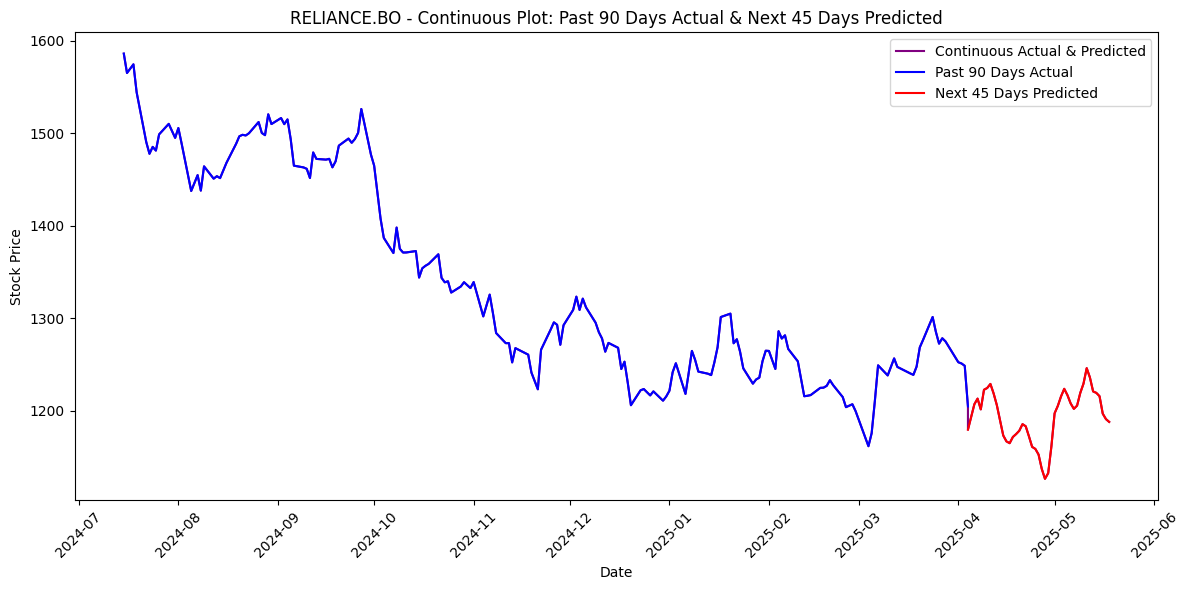

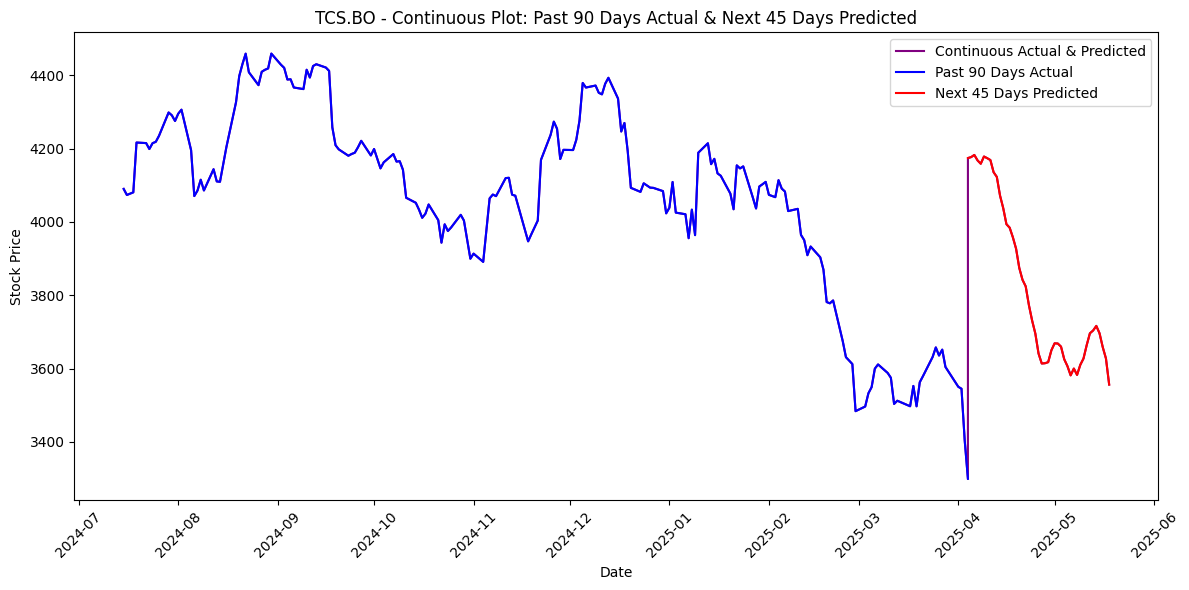

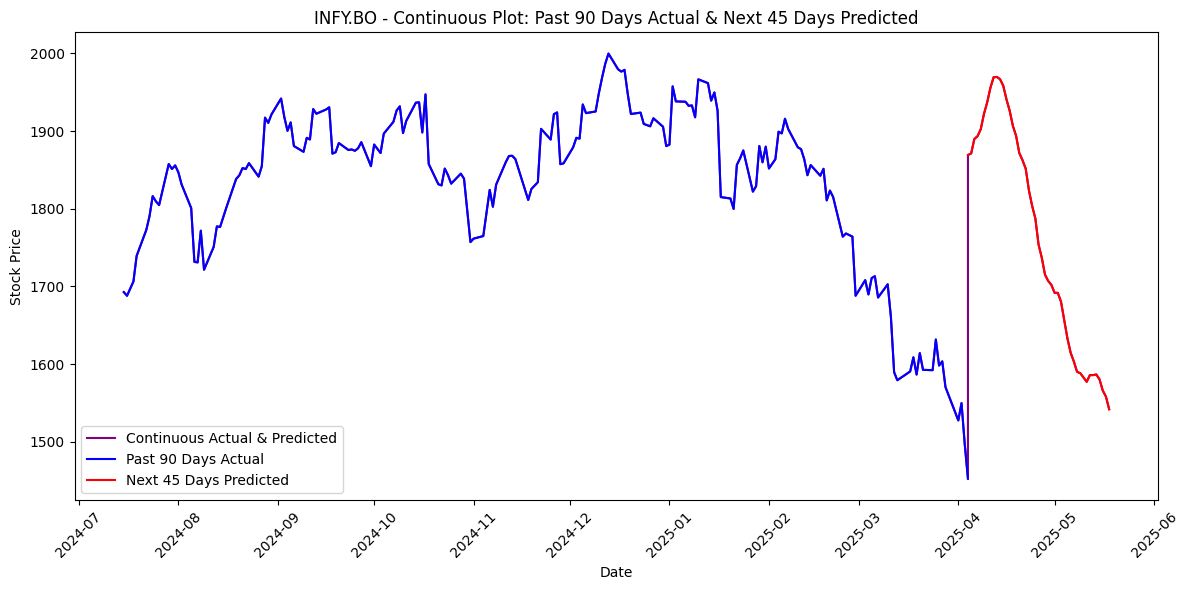

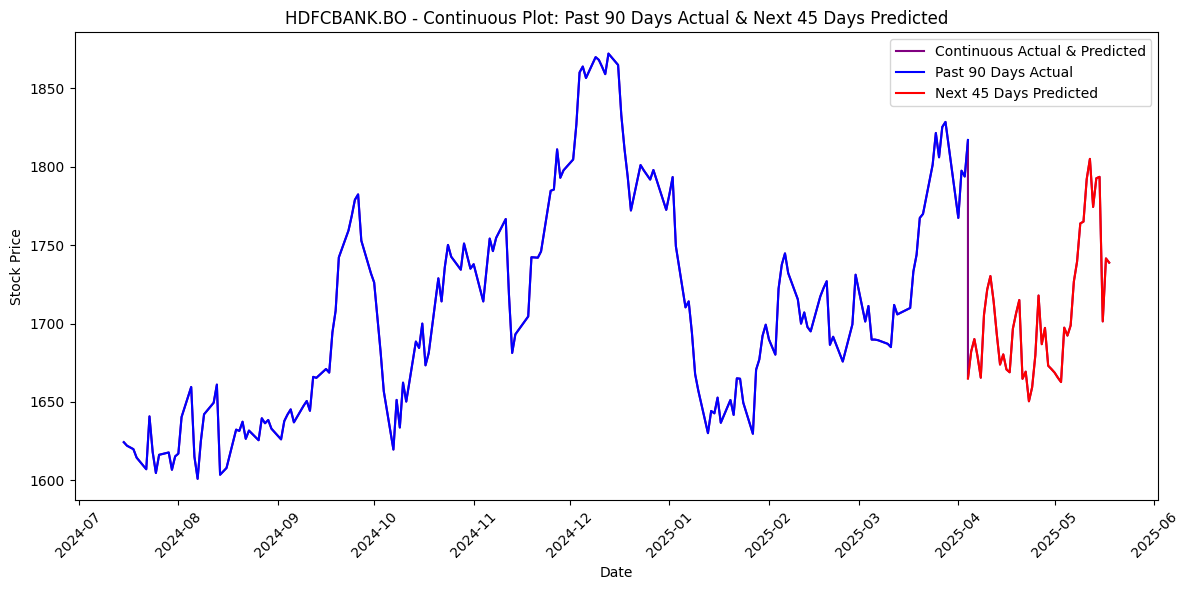

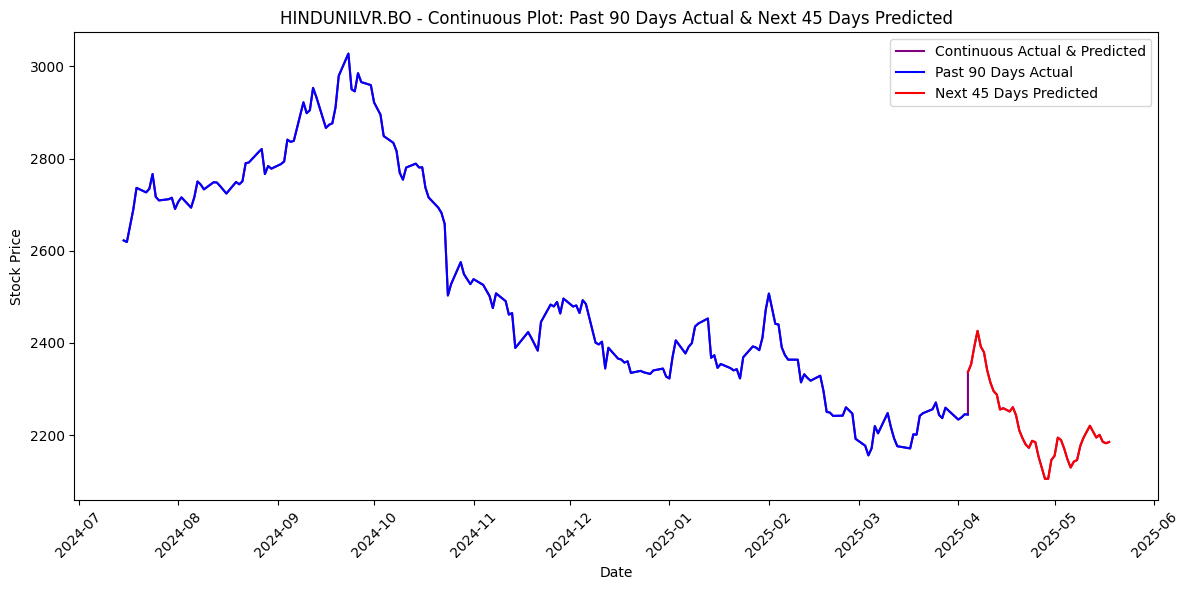

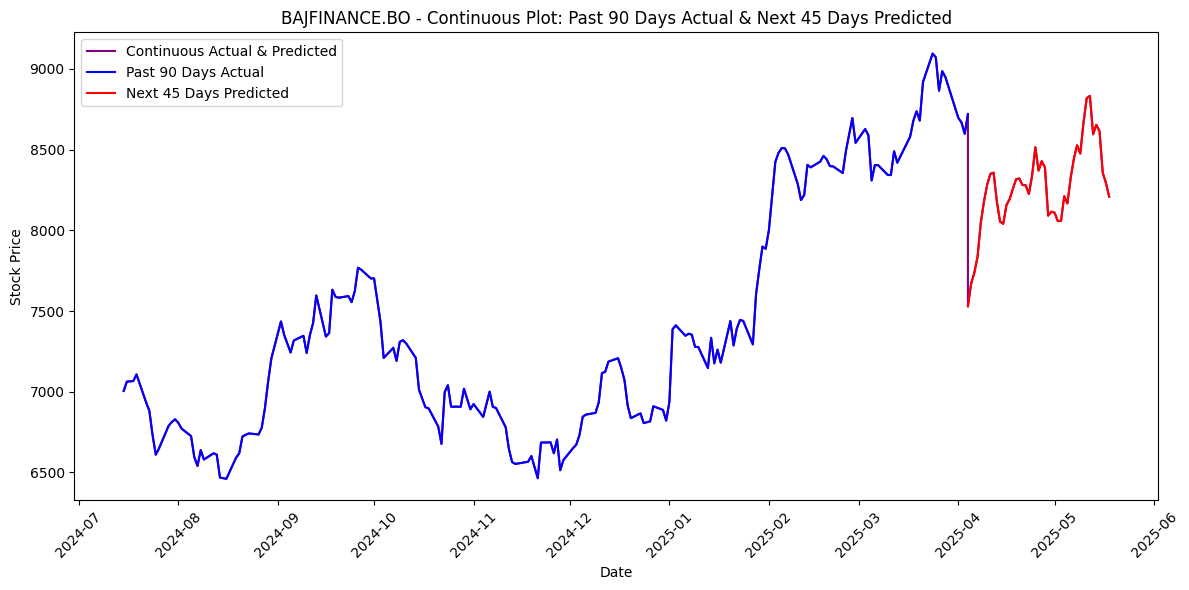

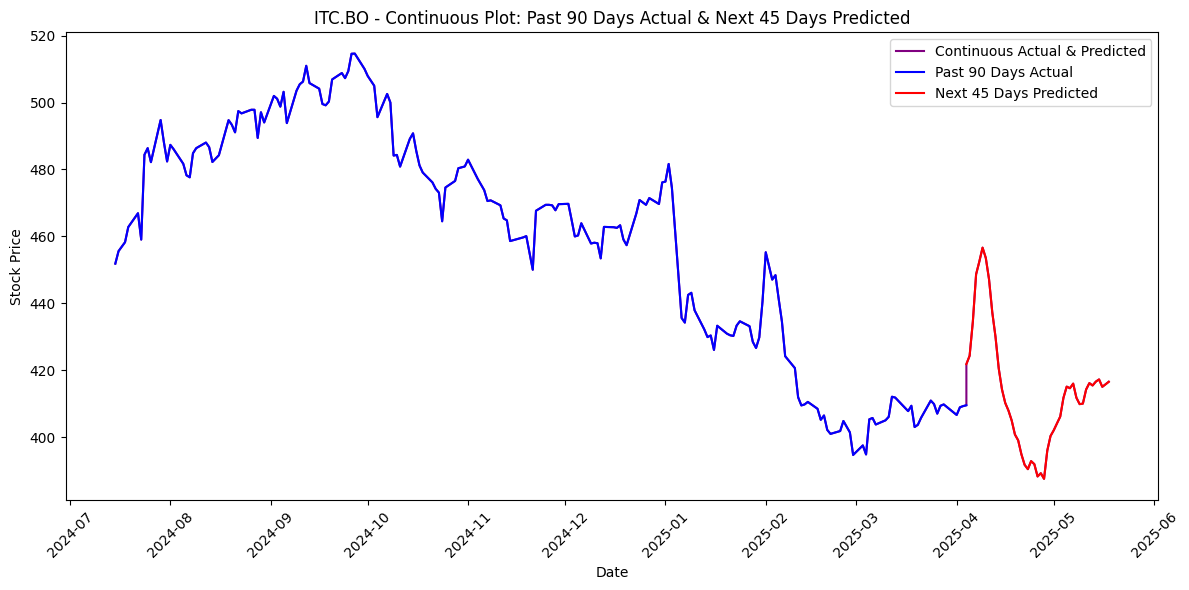

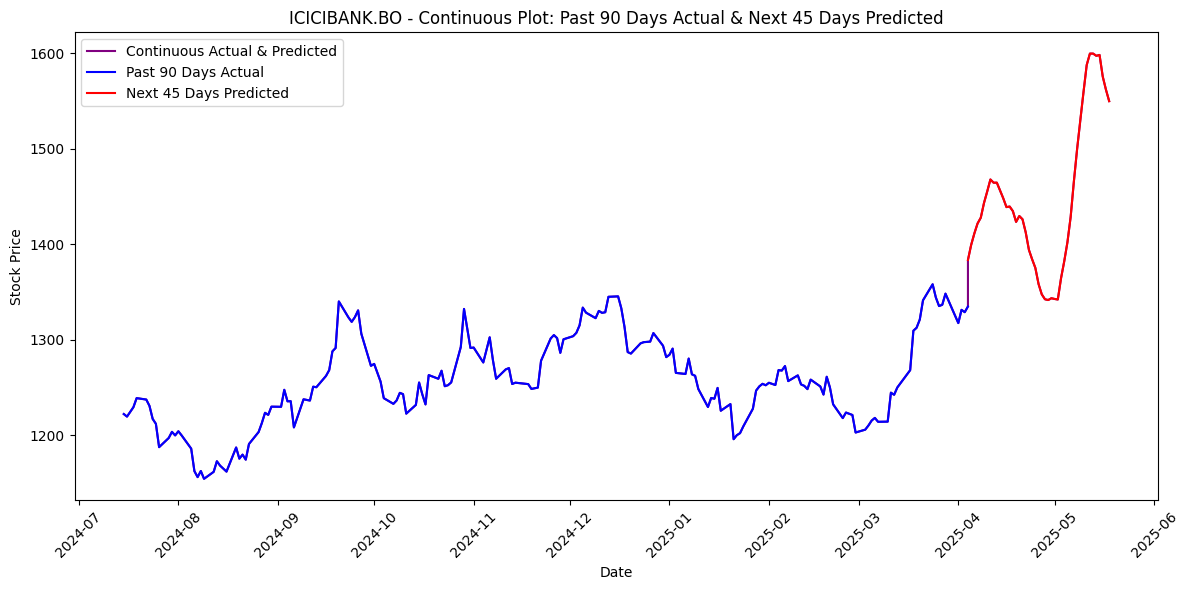

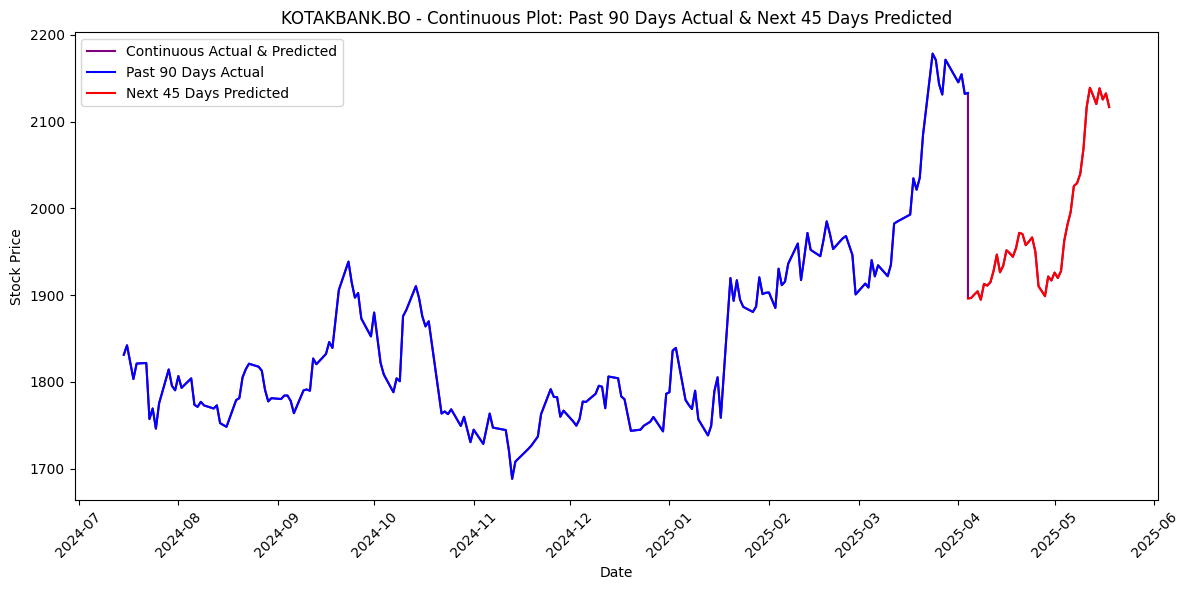

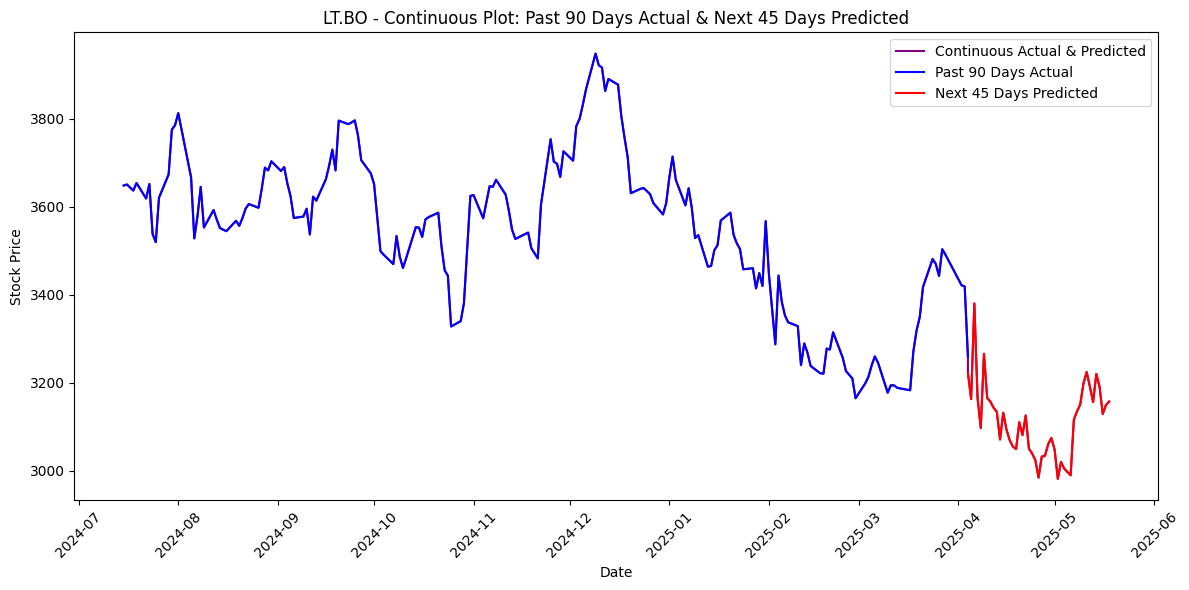

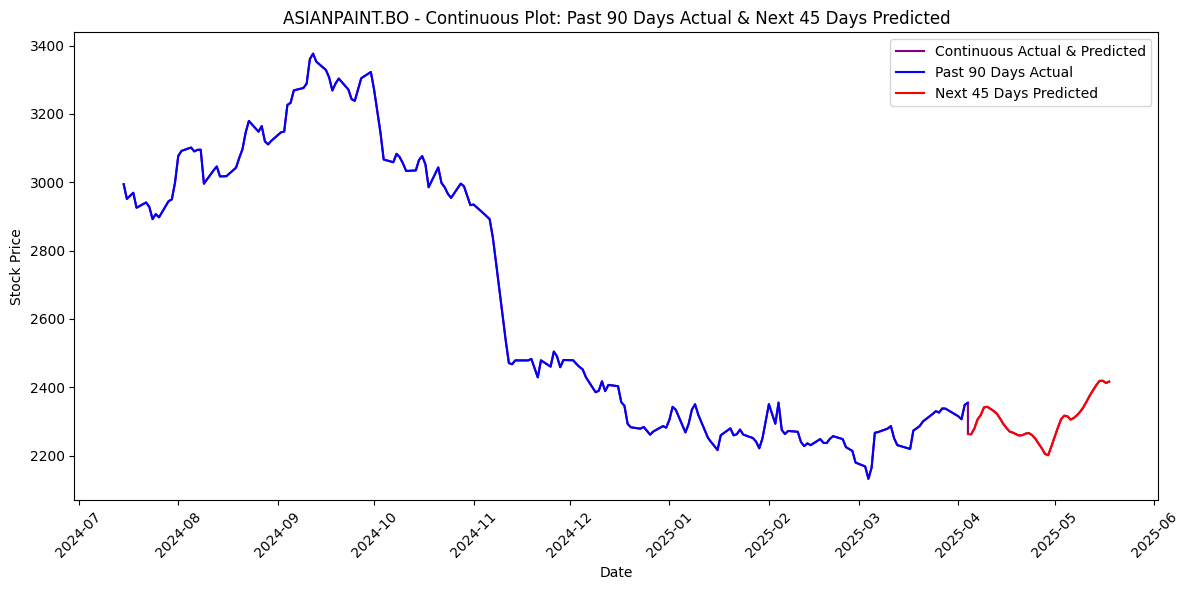

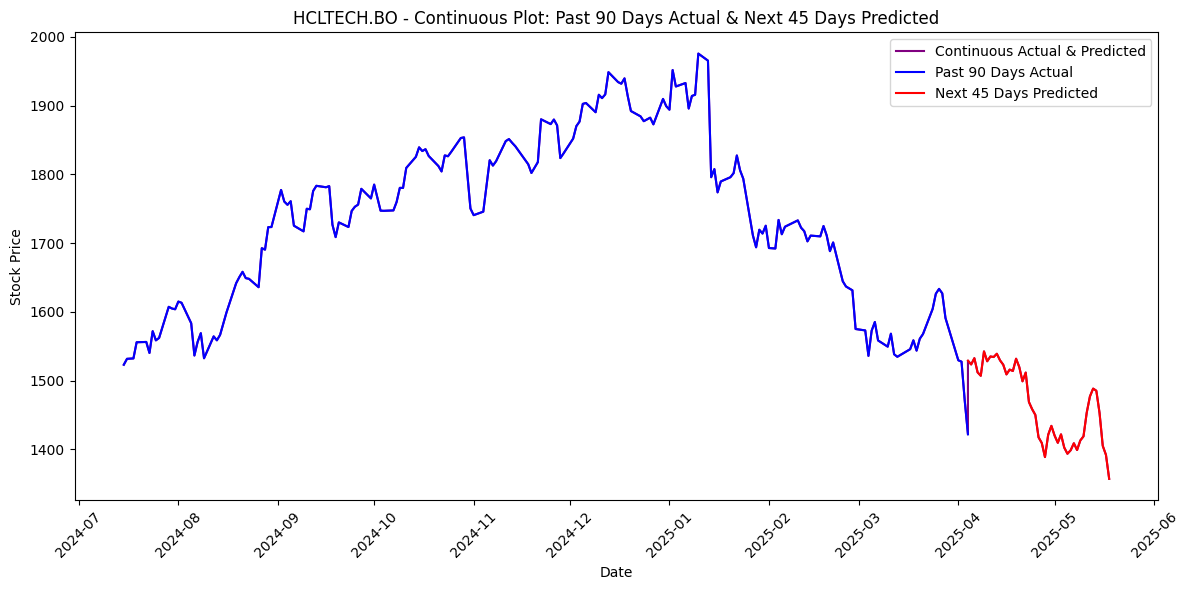

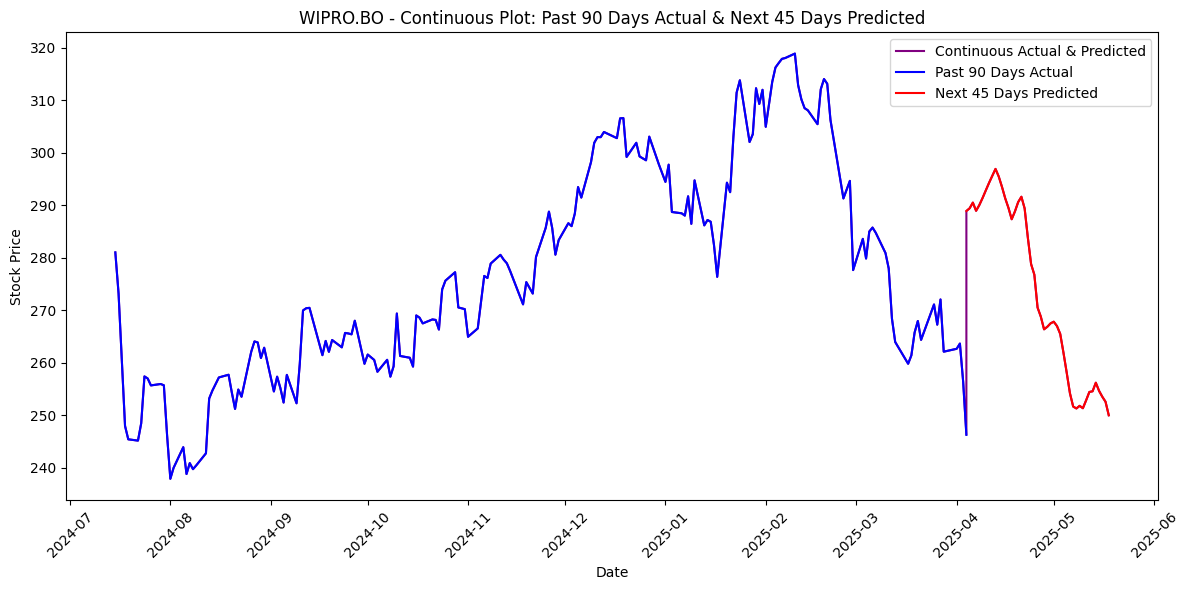

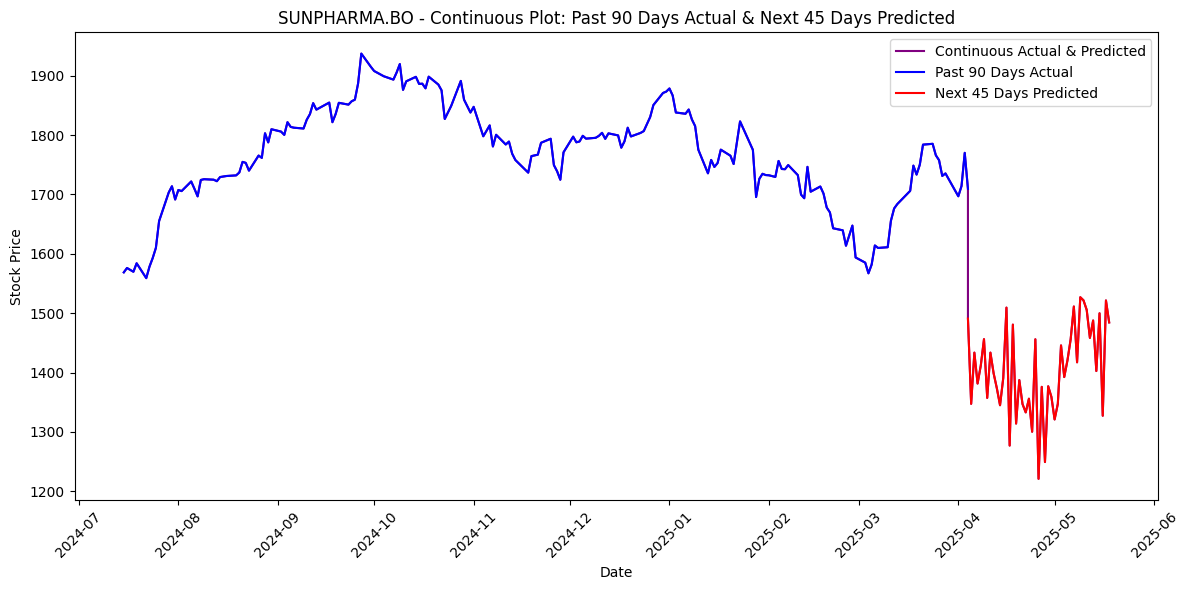

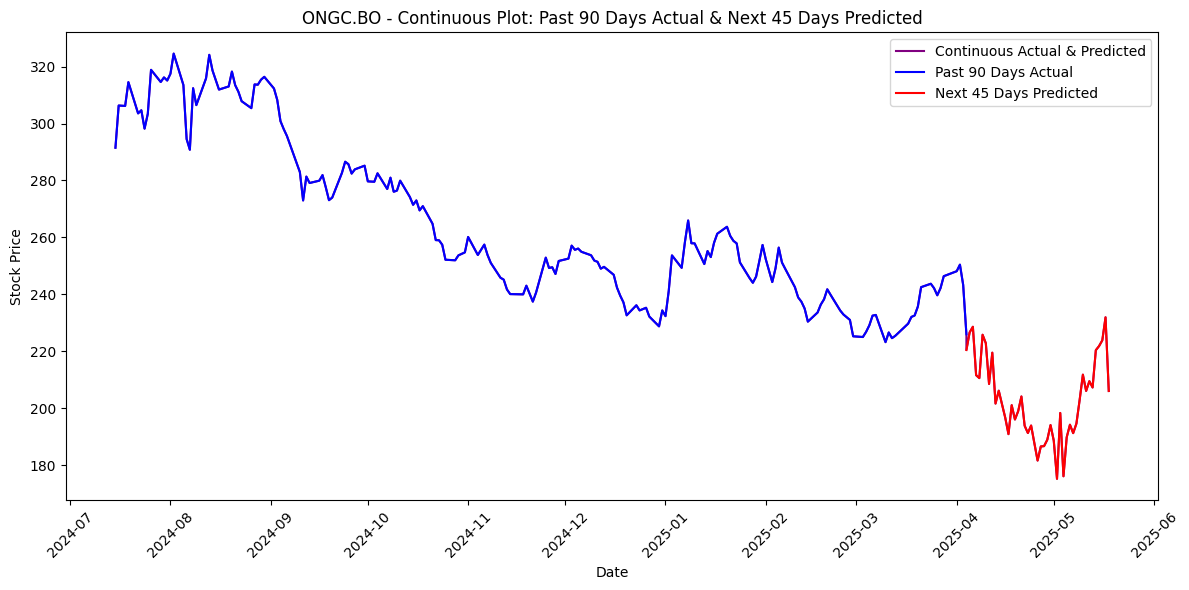

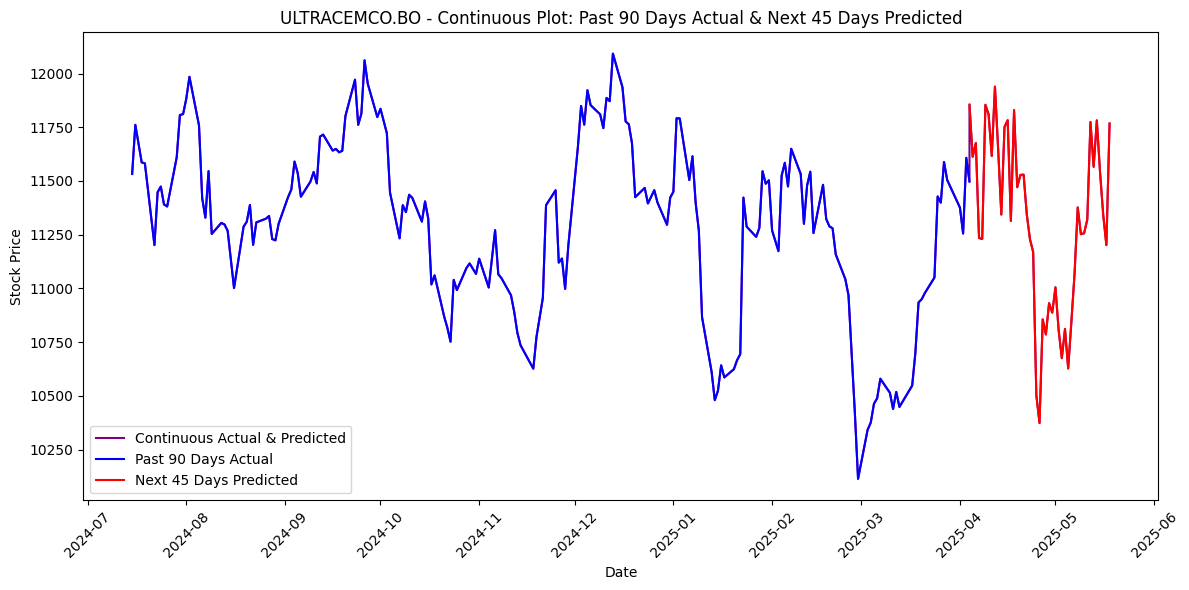

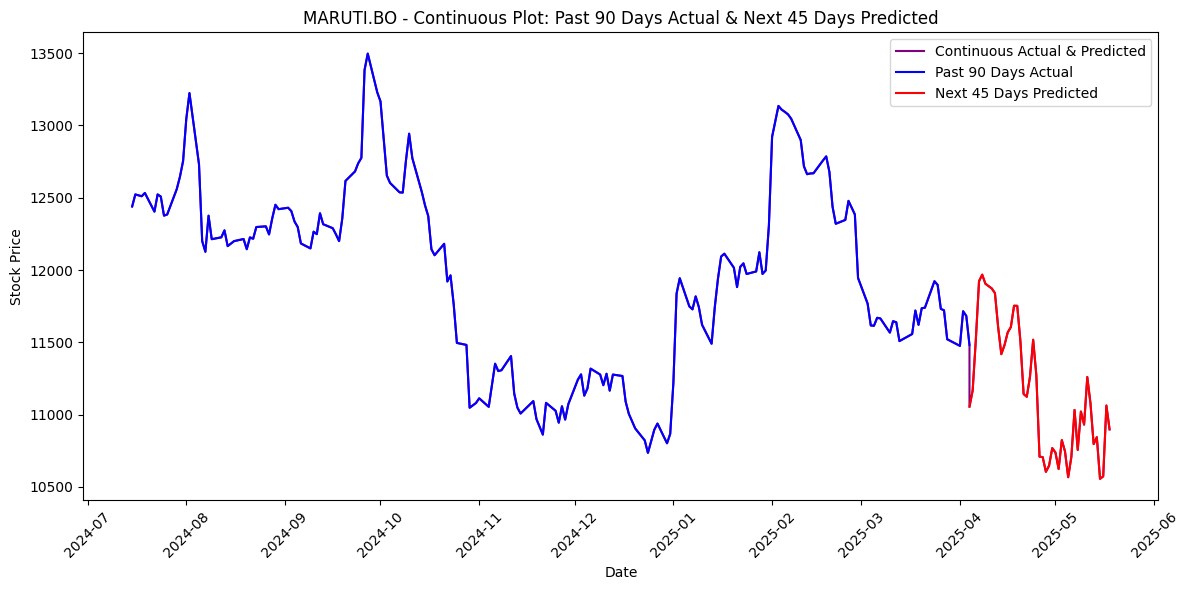

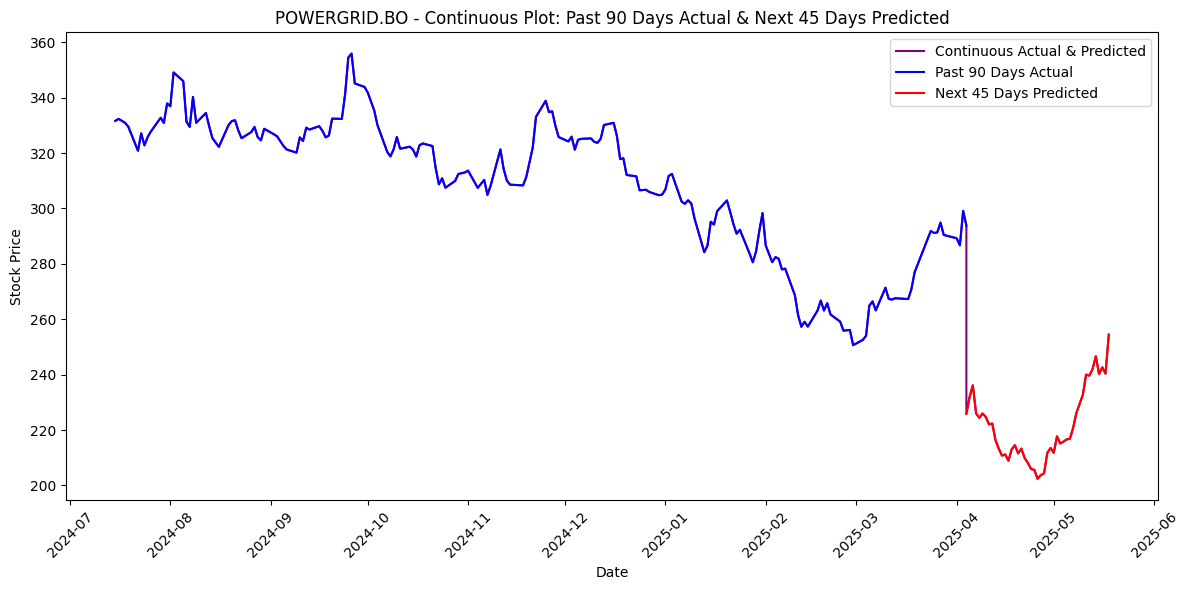

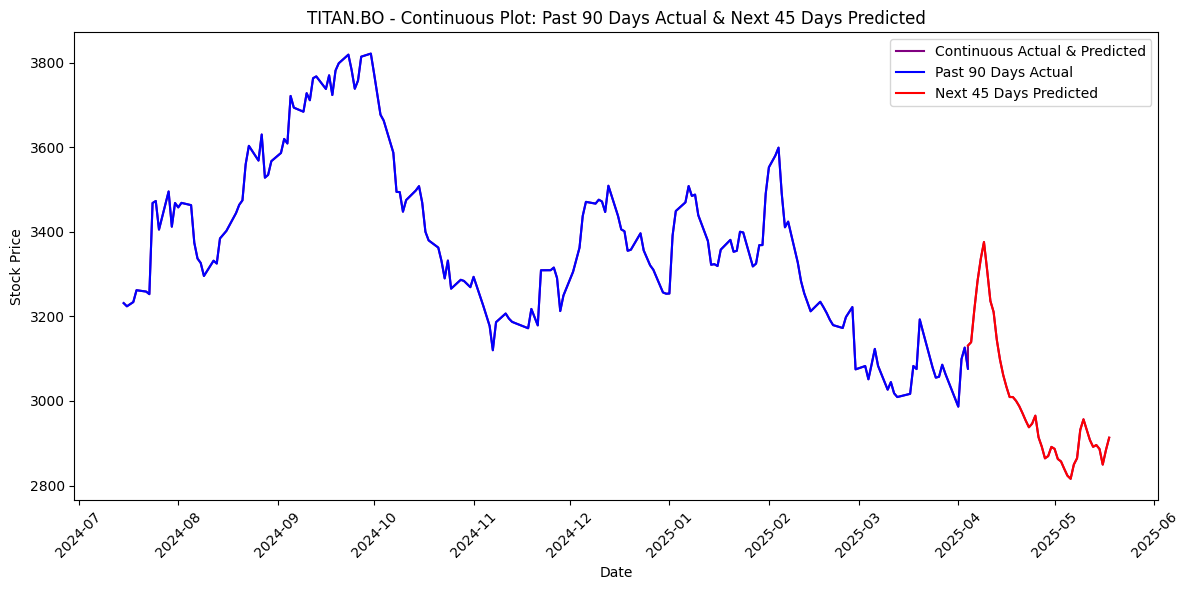

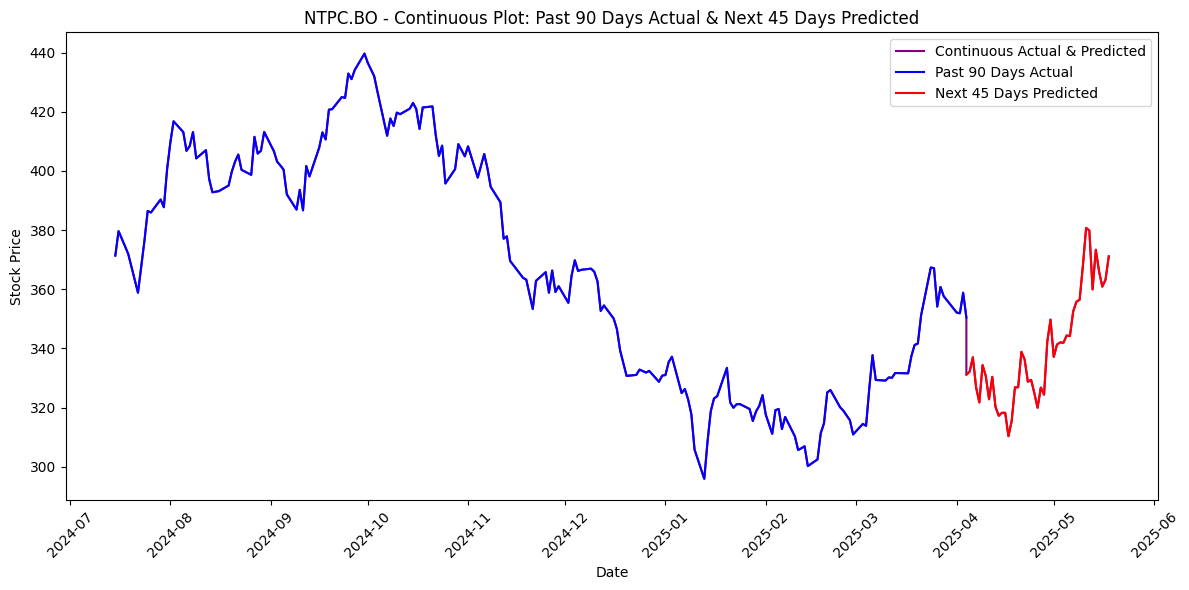

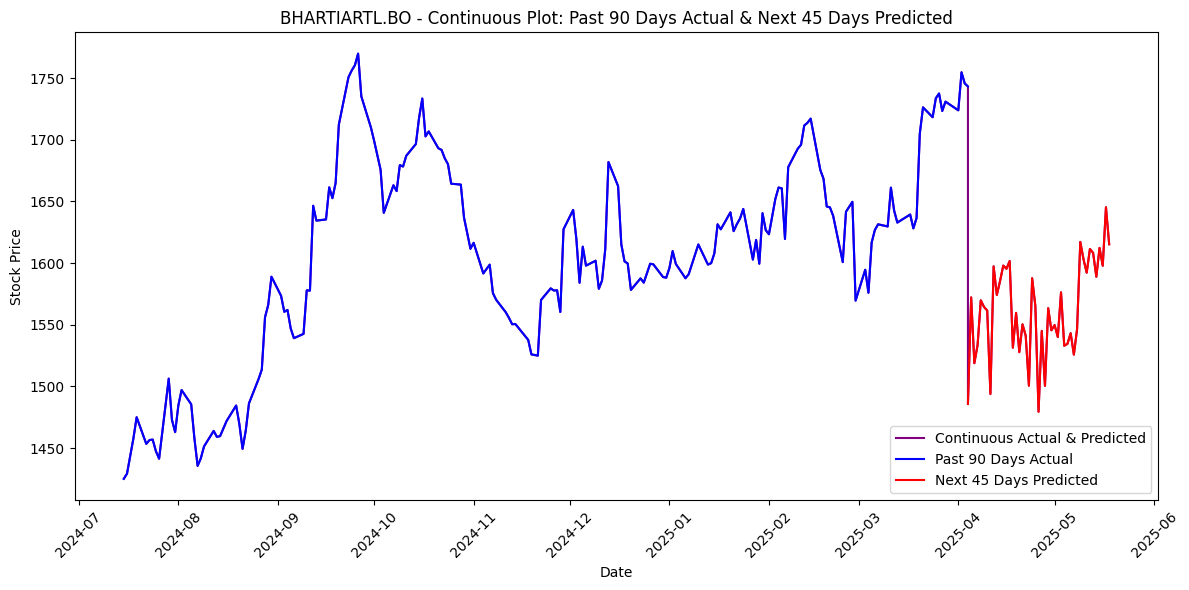

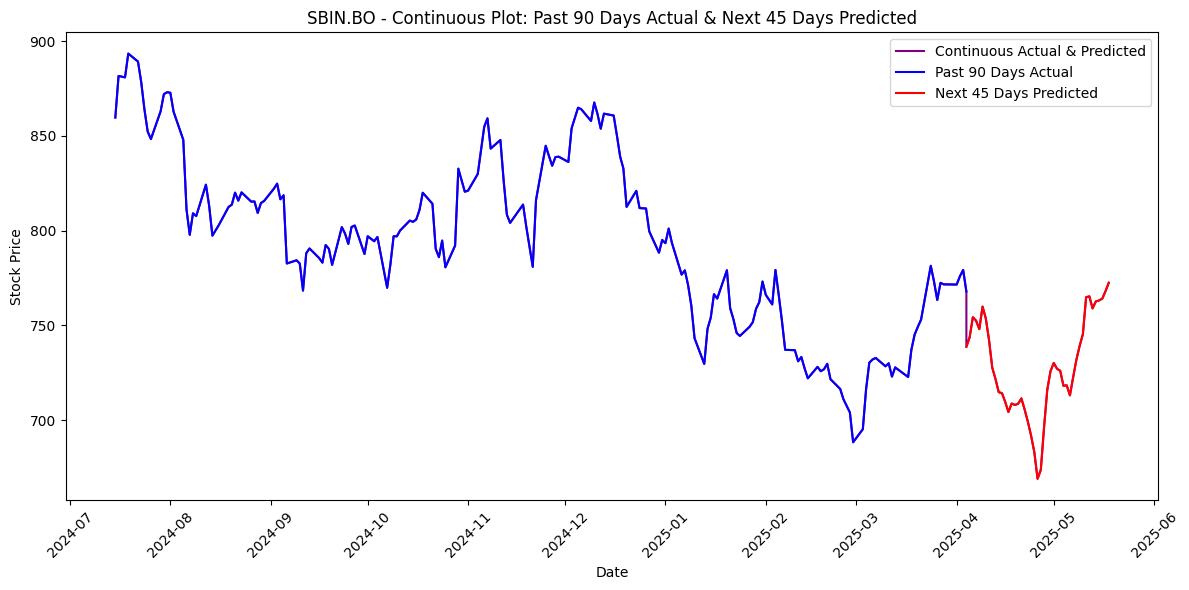

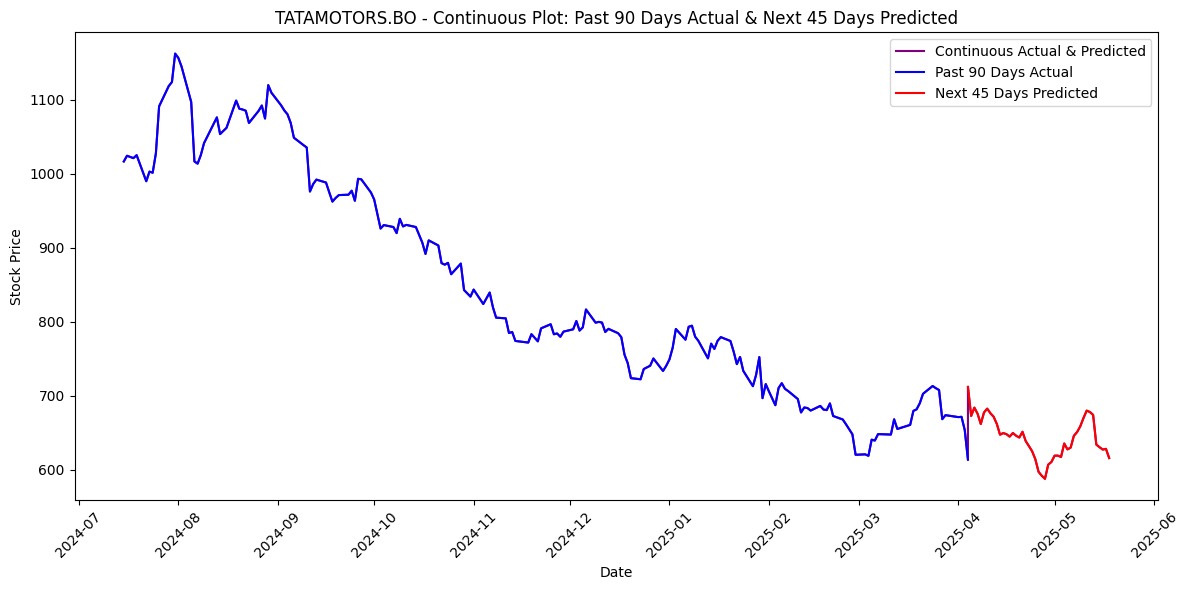

In [61]:
for ticker in STOCK_SYMBOLS:
    # Ensure the Date columns are datetime
    past_dates = pd.to_datetime(past[ticker]['Date'])
    pred_dates = pd.to_datetime(df_pred[ticker]['Date'])
    
    # Convert to numpy arrays
    combined_dates = np.concatenate([past_dates.values, pred_dates.values])
    combined_values = np.concatenate([past[ticker]['Close'].values, df_pred[ticker]['Close'].values])
    
    plt.figure(figsize=(12, 6))
    # Plot a continuous line joining the actual and forecast values
    plt.plot(combined_dates, combined_values, color='purple', label='Continuous Actual & Predicted')
    
    # Optionally, you can overlay the individual segments with different colors:
    plt.plot(past_dates, past[ticker]['Close'], label='Past 90 Days Actual', color='blue')
    plt.plot(pred_dates, df_pred[ticker]['Close'], label='Next 45 Days Predicted', color='red')
    
    plt.title(f"{ticker} - Continuous Plot: Past 90 Days Actual & Next 45 Days Predicted")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [79]:
def download_stock_data(ticker_symbol, output_folder):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=86)  # Approximately 2 months
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    
    print(f"Downloading data for {ticker_symbol} from {start_date_str} to {end_date_str}")
    
    try:
        data = yf.download(
            ticker_symbol,
            start=start_date_str,
            end=end_date_str,
            progress=False
        )
        
        if data.empty:
            print(f"No data found for {ticker_symbol}")
            return None
        
        if isinstance(data.columns, pd.MultiIndex):
            close_data = data.loc[:, ('Close', ticker_symbol)] if ('Close', ticker_symbol) in data.columns else data.loc[:, 'Close']
        else:
            close_data = data['Close']

        result_df = pd.DataFrame()
        result_df['Date'] = data.index.strftime('%Y-%m-%d')
        result_df['Close'] = close_data.values
        output_filename = os.path.join(output_folder, f"{ticker_symbol}.csv")
        result_df.to_csv(output_filename, index=False)
        print(f"Data saved to {output_filename}")
        
        return result_df
    
    except Exception as e:
        print(f"Error downloading data for {ticker_symbol}: {str(e)}")
        return None

In [80]:
output_folder = "past 2 month"
os.makedirs(output_folder, exist_ok=True)

for ticker in STOCK_SYMBOLS:
    download_stock_data(ticker, output_folder)

Data saved to past 2 month\RELIANCE.BO.csv
Data saved to past 2 month\TCS.BO.csv
Data saved to past 2 month\INFY.BO.csv
Data saved to past 2 month\HDFCBANK.BO.csv
Data saved to past 2 month\HINDUNILVR.BO.csv
Data saved to past 2 month\BAJFINANCE.BO.csv
Data saved to past 2 month\ITC.BO.csv
Data saved to past 2 month\ICICIBANK.BO.csv
Data saved to past 2 month\KOTAKBANK.BO.csv
Data saved to past 2 month\LT.BO.csv
Data saved to past 2 month\ASIANPAINT.BO.csv
Data saved to past 2 month\HCLTECH.BO.csv
Data saved to past 2 month\WIPRO.BO.csv
Data saved to past 2 month\SUNPHARMA.BO.csv
Data saved to past 2 month\ONGC.BO.csv
Data saved to past 2 month\ULTRACEMCO.BO.csv
Data saved to past 2 month\MARUTI.BO.csv
Data saved to past 2 month\POWERGRID.BO.csv
Data saved to past 2 month\TITAN.BO.csv
Data saved to past 2 month\NTPC.BO.csv
Data saved to past 2 month\BHARTIARTL.BO.csv
Data saved to past 2 month\SBIN.BO.csv
Data saved to past 2 month\TATAMOTORS.BO.csv
